In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [81]:
path = r"C:\Users\sniperpoint\Desktop\assignments\heiniken\CaseStudy\Forecasting_case_study.csv"

In [82]:
df = pd.read_csv(path)

In [83]:
df.head()

,date,Store_city,Product Name,sales
0,01-01-2013,Mexico City,Fancy Beer IPA 330 ml,18660
1,02-01-2013,Mexico City,Fancy Beer IPA 330 ml,15789
2,03-01-2013,Mexico City,Fancy Beer IPA 330 ml,20095
3,04-01-2013,Mexico City,Fancy Beer IPA 330 ml,18660
4,05-01-2013,Mexico City,Fancy Beer IPA 330 ml,14354


In [84]:
df.shape

(913000, 4)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   date          913000 non-null  object
 1   Store_city    913000 non-null  object
 2   Product Name  913000 non-null  object
 3   sales         913000 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 27.9+ MB


In [86]:
type(df['date'][0])

str

In [87]:
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

In [88]:
#extracting year, month, weekday, week from date
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['week'] = df['date'].apply(lambda x : x.isocalendar()[1])


In [89]:
df.head()

,date,Store_city,Product Name,sales,year,month,weekday,week
0,2013-01-01,Mexico City,Fancy Beer IPA 330 ml,18660,2013,1,1,1
1,2013-01-02,Mexico City,Fancy Beer IPA 330 ml,15789,2013,1,2,1
2,2013-01-03,Mexico City,Fancy Beer IPA 330 ml,20095,2013,1,3,1
3,2013-01-04,Mexico City,Fancy Beer IPA 330 ml,18660,2013,1,4,1
4,2013-01-05,Mexico City,Fancy Beer IPA 330 ml,14354,2013,1,5,1


In [90]:
df['Store_city'].value_counts()

Mexico City              91300
Guadalajara              91300
Tijuana                  91300
Ecatepec                 91300
Leon de los Aldama       91300
Puebla                   91300
Zapopan                  91300
Juarez                   91300
Monterrey                91300
Ciudad Nezahualcoyotl    91300
Name: Store_city, dtype: int64

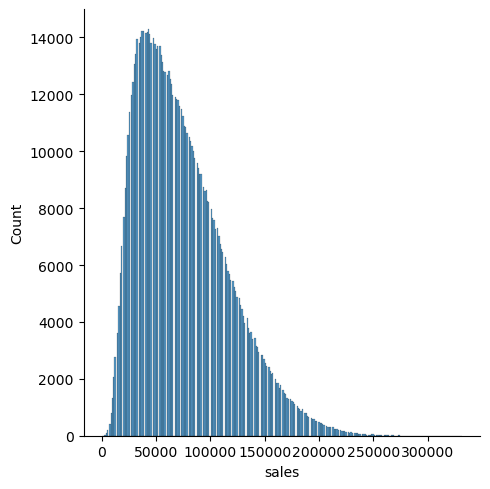

In [186]:
#sales distribution
sns.displot(df["sales"])
plt.show()

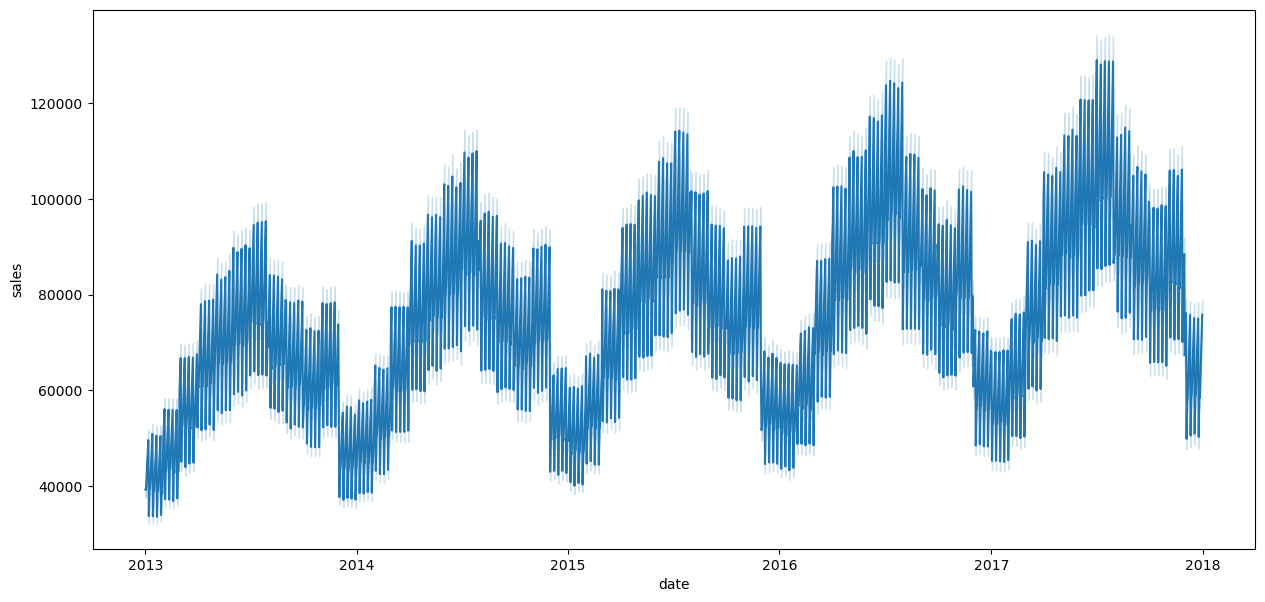

In [187]:
#sales growth every year
plt.figure(figsize=(15,7))
sns.lineplot(data=df, x="date", y="sales")
plt.show()

In [93]:
yearly_sales = df.groupby(['year'])['sales'].sum().reset_index()
yearly_sales.rename(columns = {'sales' : 'Tota_sales'}, inplace = True)
yearly_sales.head()

,year,Tota_sales
0,2013,11398467934
1,2014,13112618756
2,2015,13688775389
3,2016,14866154220
4,2017,15406678091


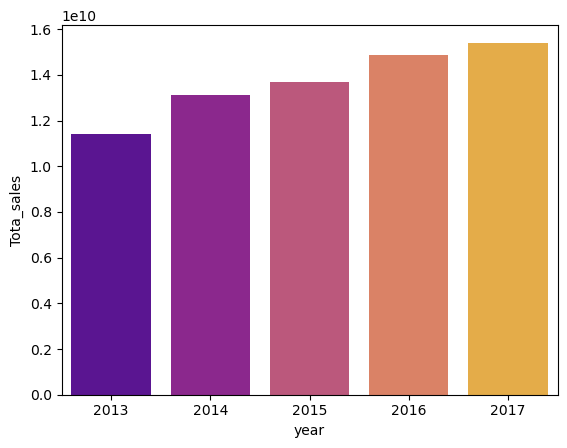

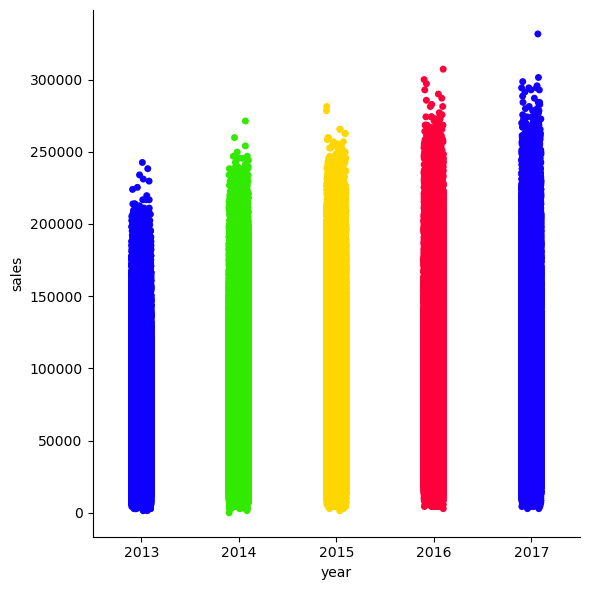

In [188]:
#Total sales per year
sns.barplot(data=yearly_sales, x="year", y="Tota_sales", palette='plasma')
sns.catplot(data=df, x="year", y="sales", palette='prism', height=6)
plt.show()

In [95]:
monthly_sales = df.groupby(['year', 'month'])['sales'].mean().reset_index()
monthly_sales.rename(columns = {'sales' : 'Avg_sales'}, inplace = True)
monthly_sales.head()

,year,month,Avg_sales
0,2013,1,42125.607032
1,2013,2,47101.757643
2,2013,3,57171.593484
3,2013,4,65286.819333
4,2013,5,70678.695419


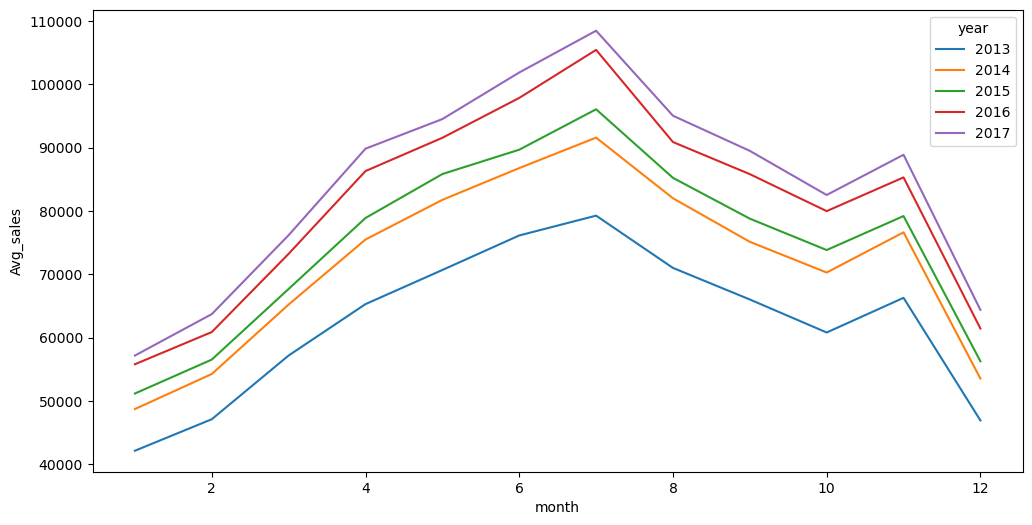

In [189]:
#avg monthly sale
plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_sales, x="month", y="Avg_sales", hue="year", palette='tab10')
plt.show()

In [97]:
weekly_sales = df.groupby(['year','week'])['sales'].mean().reset_index()
weekly_sales.rename(columns = {'sales' : 'Avg_sales'}, inplace = True)
weekly_sales.head()

,year,week,Avg_sales
0,2013,1,42726.453000
1,2013,2,42610.240000
2,2013,3,42219.817714
3,2013,4,42362.540000
4,2013,5,44712.010571


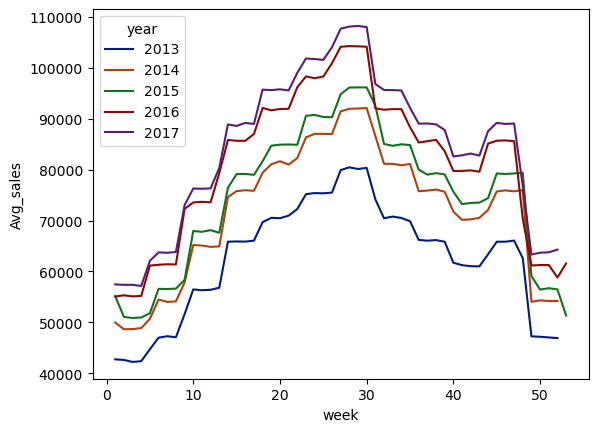

In [190]:
#avg weekly sale
sns.lineplot(data=weekly_sales, x="week", y="Avg_sales", hue="year", palette='dark')
plt.show()

In [99]:
day_wise_sales = df.groupby(['weekday'])['sales'].mean().reset_index()
day_wise_sales.rename(columns = {'sales' : 'Avg_sales'}, inplace = True)
day_wise_sales.head()

,weekday,Avg_sales
0,0,59466.058069
1,1,69221.084728
2,2,69425.759111
3,3,74240.946245
4,4,79169.982261


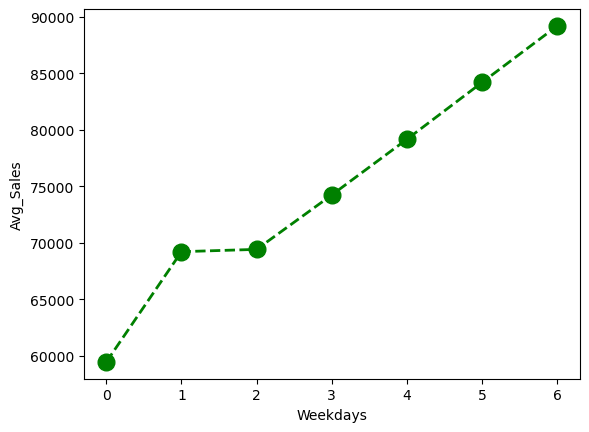

In [191]:
#avg daily sales
plt.plot(day_wise_sales['weekday'], day_wise_sales['Avg_sales'], color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
plt.xlabel("Weekdays")
plt.ylabel("Avg_Sales")
plt.show()

In [101]:
product_wise_sales = df.groupby(['Product Name'])['sales'].sum().reset_index()
product_wise_sales.rename(columns = {'sales' : 'Tota_sales'}, inplace = True)
product_wise_sales.sort_values('Tota_sales', ascending = True, inplace = True)
product_wise_sales.head()

,Product Name,Tota_sales
34,Fancy Beer Rye Beer 330 ml,481173002
20,Fancy Beer IPA 330 ml,576127092
33,Fancy Beer Rye Beer 1 pint,576665342
27,Fancy Beer Pale Ale 500 ml,576696879
7,Fancy Beer Beer 1 pint,576877702


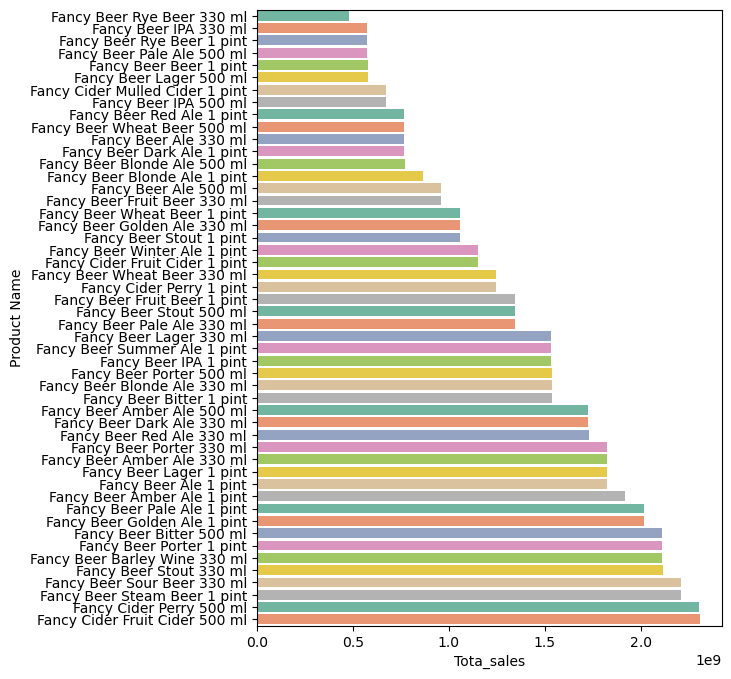

In [192]:
#Total sales made by each product
plt.figure(figsize=(6, 8))
sns.barplot(data=product_wise_sales, x="Tota_sales", y="Product Name", palette='Set2')
plt.show()

In [103]:
city_wise_sales = df.groupby(['Store_city'])['sales'].sum().reset_index()
city_wise_sales.rename(columns = {'sales' : 'Total_sales'}, inplace = True)
city_wise_sales.sort_values('Total_sales', ascending = False, inplace = True)
city_wise_sales.head()

,Store_city,Total_sales
2,Guadalajara,8784527991
3,Juarez,8405654443
8,Tijuana,7801336221
0,Ciudad Nezahualcoyotl,7693704981
6,Monterrey,7214036709


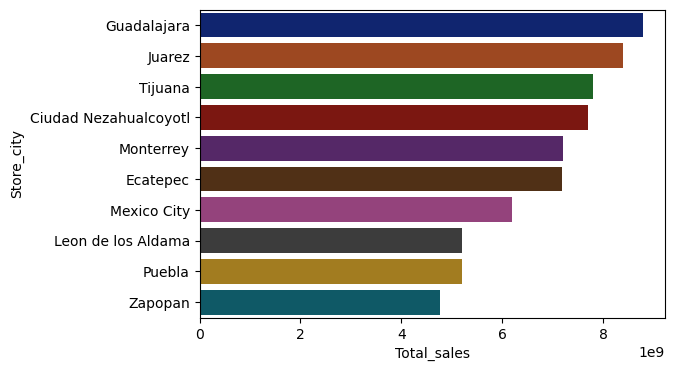

In [193]:
#total sales in each city
plt.figure(figsize=(6, 4))
sns.barplot(data=city_wise_sales, x="Total_sales", y="Store_city", palette='dark')
plt.show()

In [105]:
city_gowth = df.groupby(['year', 'Store_city'])['sales'].mean().reset_index()
city_gowth.rename(columns = {'sales' : 'Avg_sales'}, inplace = True)
city_gowth.head()

,year,Store_city,Avg_sales
0,2013,Ciudad Nezahualcoyotl,70261.236274
1,2013,Ecatepec,65676.840767
2,2013,Guadalajara,80241.041644
3,2013,Juarez,76655.971890
4,2013,Leon de los Aldama,47487.150411


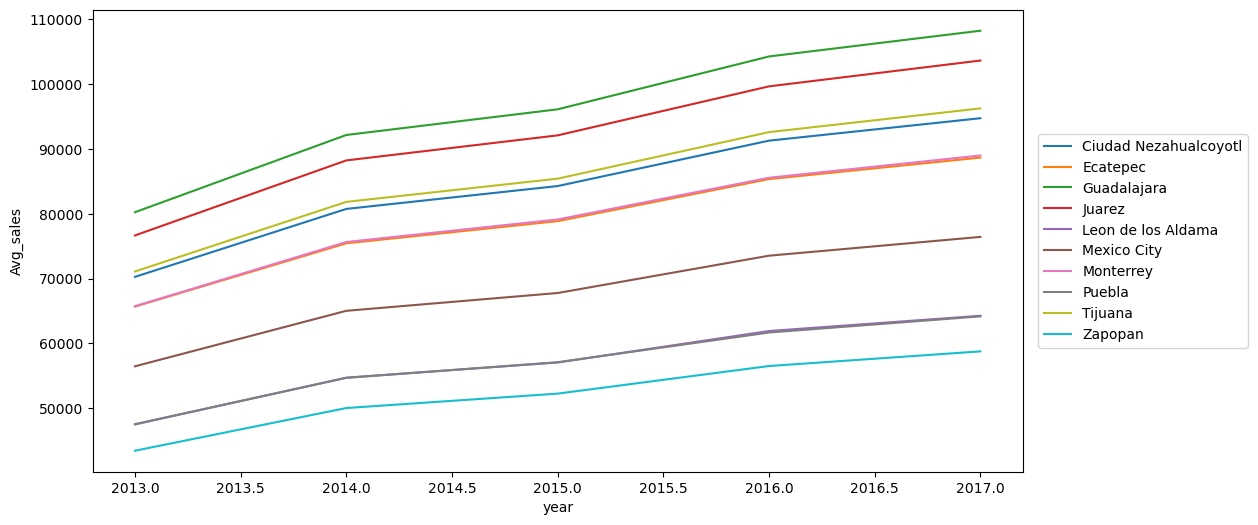

In [194]:
#sale growth in city year by year
plt.figure(figsize=(12, 6))
sns.lineplot(data=city_gowth, x="year", y="Avg_sales", hue="Store_city", palette='tab10')
plt.legend(loc='center right', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.show()

In [107]:
count = df.groupby(['Store_city', 'Product Name'])['sales'].count().reset_index()
print(count['sales'].unique())

[1826]


# All combinations of 'Store_city' and 'Product Name' are same i.e. 1826 datapoints. So we will consider one combination and try to predict the sales of that.

In [108]:
#Extracting that combination which has highest avg sales
max_sales = df.groupby(['Store_city', 'Product Name'])['sales'].mean().reset_index()
max_sales.sort_values('sales', ascending = False, inplace = True)
max_sales.head(1)

,Store_city,Product Name,sales
149,Guadalajara,Fancy Cider Perry 500 ml,161674.983023


# Now we will consider combination that have highest sales

In [109]:
#Extracting data
obs_1 = df[(df['Store_city'] == 'Guadalajara') & (df['Product Name'] == 'Fancy Cider Perry 500 ml')]
obs_1 = obs_1.drop(columns = {'Store_city', 'Product Name', 'date'}).reset_index(drop = True)


In [110]:
obs_1.columns

Index(['sales', 'year', 'month', 'weekday', 'week'], dtype='object')

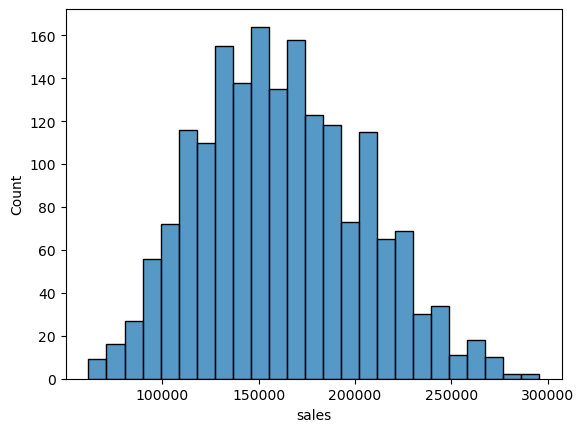

In [195]:
#sales distribution
sns.histplot(obs_1['sales'])
plt.show()

In [112]:
obs_1['year'].unique()

array([2013, 2014, 2015, 2016, 2017], dtype=int64)

In [113]:
def labell(x):
    dic = {2013:1, 2014:2, 2015:3, 2016:4, 2017:5}
    return dic[x]
    

In [114]:
#encoding year column
obs_1['year'] = obs_1['year'].apply(lambda x: labell(x))


In [115]:
obs_1.head()

,sales,year,month,weekday,week
0,64591,1,1,1,1
1,76074,1,1,2,1
2,93298,1,1,3,1
3,94733,1,1,4,1
4,139229,1,1,5,1


In [116]:
X1 = obs_1.drop(columns = 'sales')
y1 = obs_1['sales']


In [117]:
#transformation of data 
from scipy.stats import zscore

X1 =X1.apply(zscore)


# Lets create january 2018 data for prediction

In [118]:
date_range = pd.date_range(start='01-01-2018', end='31-01-2018')
X_final_test = pd.DataFrame({'date': date_range})

C:\Users\sniperpoint\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3457: UserWarning: Parsing '31-01-2018' in DD/MM/YYYY format. Provide format or specify infer_datetime_format=True for consistent parsing.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [119]:
type(X_final_test['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [120]:
X_final_test['year'] = X_final_test['date'].dt.year
X_final_test['month'] = X_final_test['date'].dt.month
X_final_test['weekday'] = X_final_test['date'].dt.weekday
X_final_test['week'] = X_final_test['date'].apply(lambda x : x.isocalendar()[1])

In [121]:
X_final_test.drop(columns = 'date', inplace = True)

In [122]:
X_final_test.head()

,year,month,weekday,week
0,2018,1,0,1
1,2018,1,1,1
2,2018,1,2,1
3,2018,1,3,1
4,2018,1,4,1


In [123]:
#remove multicollinearity by using VIF technique
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

In [124]:
calc_vif(X1[[i for i in X1.columns]])

,variables,VIF
0,year,1.000447
1,month,16.507888
2,weekday,1.000010
3,week,16.508240


# We can remove multicollinearity using PCA

In [125]:
def get_pca(x):
    pca=PCA(n_components=3)
    pca.fit(x)
    x_pca=pca.transform(x)
    return pd.DataFrame(x_pca)

In [126]:
X1 =get_pca(X1)

In [127]:
calc_vif(X1[[i for i in X1.columns]])

,variables,VIF
0,0,1.0
1,1,1.0
2,2,1.0


In [128]:
X1.head()

,0,1,2
0,-2.337398,1.707210,-0.282775
1,-2.338442,1.353833,-0.636745
2,-2.339486,1.000455,-0.990715
3,-2.340530,0.647078,-1.344685
4,-2.341574,0.293701,-1.698655


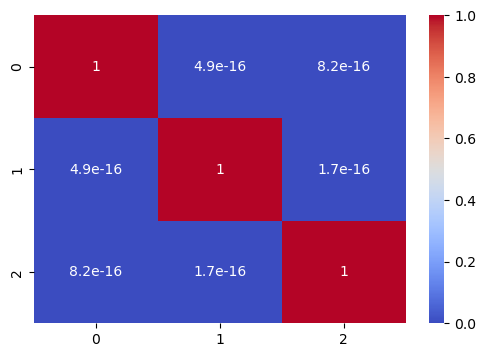

In [198]:
#check for correlation
plt.figure(figsize=(6,4))
correlation = X1.corr()
sns.heatmap(abs(correlation), annot=True, cmap='coolwarm')
plt.show()

In [130]:
#splitting train and test data
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.2, shuffle = False)


In [131]:
X1_train.shape

(1460, 3)

In [132]:
#create a function to compute Evaluation matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def get_evaluation_matrix(y_test, y_pred):
    
    MAE = np.mean(np.abs(y_test - y_pred))
    
    MAPE = np.sum(np.abs(y_test - y_pred))/np.sum(y_test) * 100
    
    lst = [MAE, MAPE]
    return lst

In [133]:
performance = pd.DataFrame(index = ['MAE', 'MAPE'])

In [134]:
def random_forest(X_train, y_train, X_test):
    max_depth=[13,14,15,16,17,18,19,20]
    min_samples_leaf=[10,11,12,13,14,15]
    n_estimators = [4,5,6,7,8]
    
    params = {'max_depth' :max_depth, 'min_samples_leaf': min_samples_leaf, 'n_estimators' : n_estimators}
    
    regressor_rf = GridSearchCV(RandomForestRegressor(), param_grid=params,verbose=0)
       
    #fitting model
    regressor_rf.fit(X_train, y_train)
    score = regressor_rf.score(X_train, y_train)
    
    #prediction for RandomForest
    y_pred_train = regressor_rf.predict(X_train)
    y_pred_test = regressor_rf.predict(X_test)
    
    return y_pred_train, y_pred_test, score
    

In [135]:
#prediction
y_pred_train, y_pred_test, rf1_train_score = random_forest(X1_train, y1_train, X1_test)

In [136]:
#training score
rf1_train_score

0.8536603429188432

In [137]:
y1_test

1460    132052
1461    127746
1462     87556
1463    150712
1464    123440
         ...  
1821    117699
1822    163630
1823    144970
1824    172242
1825    149276
Name: sales, Length: 366, dtype: int64

In [138]:
index = [i for i in range(1460, 1826)]

In [139]:
y1_test = pd.DataFrame(y1_test)

In [140]:
y1_test['index'] = index

In [141]:
y1_test.set_index('index', inplace = True)

In [142]:
y1_test.head()

,sales
index,
1460,132052
1461,127746
1462,87556
1463,150712
1464,123440


In [143]:
y1_test['y_pred_test'] = y_pred_test

In [144]:
#Evaluation matrices for linear regression
result = get_evaluation_matrix(y1_test['sales'],y_pred_test)
performance['random_forest'] = result
performance

,random_forest
MAE,19183.635008
MAPE,10.582231


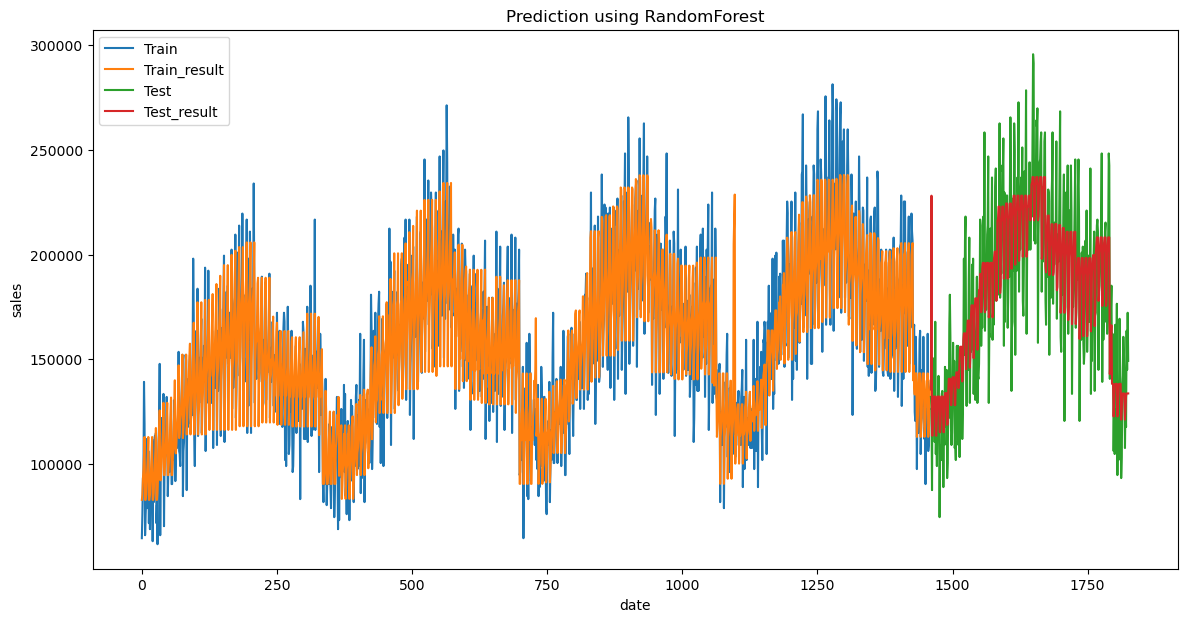

In [196]:
#plot target test and predicted value for DecisionTree
plt.figure(figsize=(14,7))
plt.plot(y1_train, label='Train')
plt.plot(y_pred_train, label='Train_result')
plt.plot(y1_test['sales'], label='Test')
plt.plot(y1_test['y_pred_test'], label='Test_result')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Prediction using RandomForest')
plt.show()

# Now we will do forecasting using ARIMA & SARIMA for same combination

In [146]:
#extracting data
obs_1 = df[(df['Store_city'] == 'Guadalajara') & (df['Product Name'] == 'Fancy Cider Perry 500 ml')]


In [147]:
obs_1.head()

,date,Store_city,Product Name,sales,year,month,weekday,week
494846,2013-01-01,Guadalajara,Fancy Cider Perry 500 ml,64591,2013,1,1,1
494847,2013-01-02,Guadalajara,Fancy Cider Perry 500 ml,76074,2013,1,2,1
494848,2013-01-03,Guadalajara,Fancy Cider Perry 500 ml,93298,2013,1,3,1
494849,2013-01-04,Guadalajara,Fancy Cider Perry 500 ml,94733,2013,1,4,1
494850,2013-01-05,Guadalajara,Fancy Cider Perry 500 ml,139229,2013,1,5,1


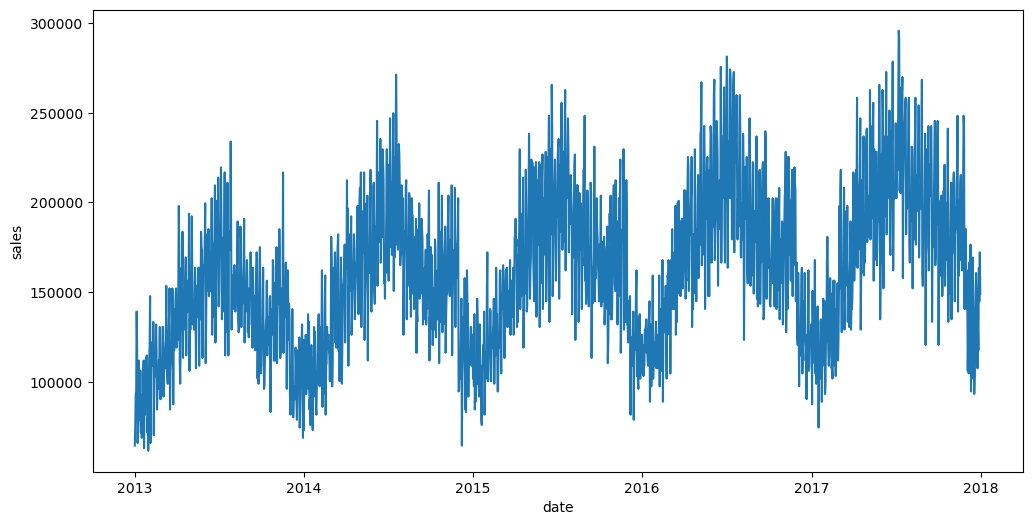

In [197]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=obs_1, x = 'date' , y="sales")
plt.show()

# Before applying timeseries model we need to check for stationarity

In [149]:
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [150]:
test_result=adfuller(obs_1['sales'])

# from the above result, we can see that data is stationary 

C:\Users\sniperpoint\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


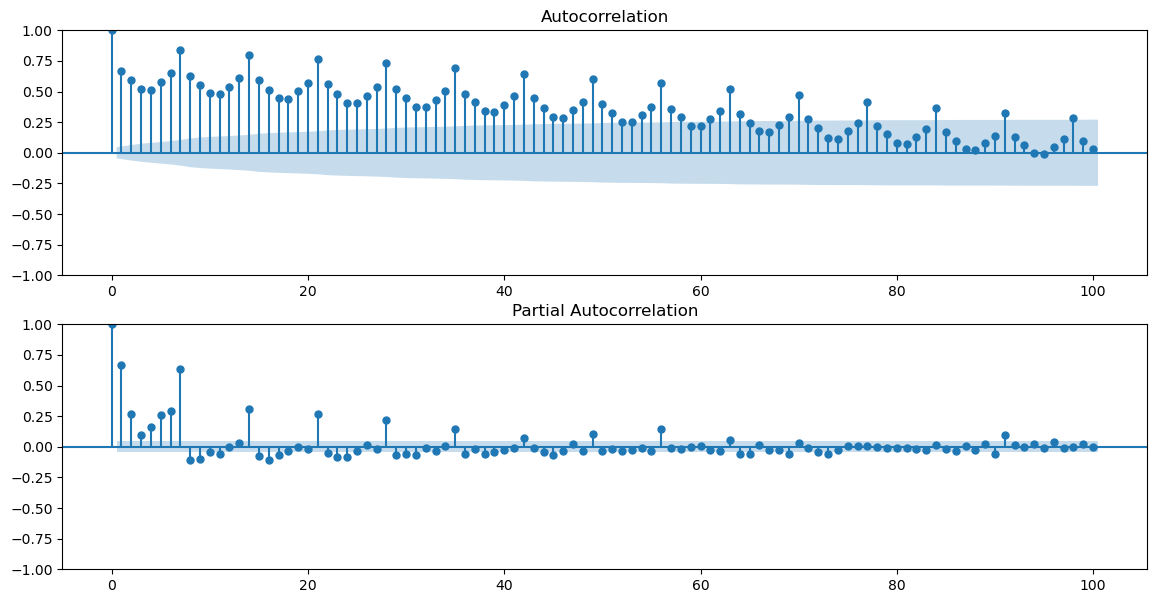

In [199]:
# Autocorrelation Plots
fig, ax = plt.subplots(2, figsize=(14,7))
ax[0] = plot_acf(obs_1['sales'], ax=ax[0], lags=100)
ax[1] = plot_pacf(obs_1['sales'], ax=ax[1], lags=100)
plt.show()

In [152]:
obs_1.head()

,date,Store_city,Product Name,sales,year,month,weekday,week
494846,2013-01-01,Guadalajara,Fancy Cider Perry 500 ml,64591,2013,1,1,1
494847,2013-01-02,Guadalajara,Fancy Cider Perry 500 ml,76074,2013,1,2,1
494848,2013-01-03,Guadalajara,Fancy Cider Perry 500 ml,93298,2013,1,3,1
494849,2013-01-04,Guadalajara,Fancy Cider Perry 500 ml,94733,2013,1,4,1
494850,2013-01-05,Guadalajara,Fancy Cider Perry 500 ml,139229,2013,1,5,1


In [155]:
#splitting train and test data
t = obs_1.set_index('date')
train_df = t.loc[:'2017-09-30'].reset_index(drop=False)                         
test_df = t.loc['2017-10-01':].reset_index(drop=False)

In [156]:
t

,Store_city,Product Name,sales,year,month,weekday,week
date,,,,,,,
2013-01-01,Guadalajara,Fancy Cider Perry 500 ml,64591,2013,1,1,1
2013-01-02,Guadalajara,Fancy Cider Perry 500 ml,76074,2013,1,2,1
2013-01-03,Guadalajara,Fancy Cider Perry 500 ml,93298,2013,1,3,1
2013-01-04,Guadalajara,Fancy Cider Perry 500 ml,94733,2013,1,4,1
2013-01-05,Guadalajara,Fancy Cider Perry 500 ml,139229,2013,1,5,1
...,...,...,...,...,...,...,...
2017-12-27,Guadalajara,Fancy Cider Perry 500 ml,117699,2017,12,2,52
2017-12-28,Guadalajara,Fancy Cider Perry 500 ml,163630,2017,12,3,52
2017-12-29,Guadalajara,Fancy Cider Perry 500 ml,144970,2017,12,4,52


In [157]:
obs1_train = train_df[['date', 'sales']]
obs1_test = test_df[['date', 'sales']]

In [158]:
obs1_test.iloc[0]

date     2017-10-01 00:00:00
sales                 218173
Name: 0, dtype: object

In [159]:
from statsmodels.tsa.arima.model import ARIMA

In [160]:
#applying arima for training set
arima = ARIMA(obs1_train['sales'],
                order=(1,1,7))
arima_train_result = arima.fit().predict()

In [161]:
#applying arima for training set
arima = ARIMA(obs1_test['sales'],
                order=(1,1,7))
arima_test_result = arima.fit().predict()

In [162]:
#calculating error
arima_err = obs1_test['sales'] - arima_test_result

In [163]:
arima_err.head()

0    218173.000000
1      5324.220293
2     17884.294116
3     47162.433169
4     24072.229437
dtype: float64

In [164]:
def mae(err):
    return np.mean(np.abs(err))


def mape(err, sales=obs1_test['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

In [165]:
#print MAE MAPE
print(f'MAE Score : ', mae(arima_err))
print(f'MAPE Score : ', mape(arima_err))

MAE Score :  23296.89115211703
MAPE Score :  13.812178068860712


In [166]:
performance['ARIMA'] = [mae(arima_err), mape(arima_err)]
performance

,random_forest,ARIMA
MAE,19183.635008,23296.891152
MAPE,10.582231,13.812178


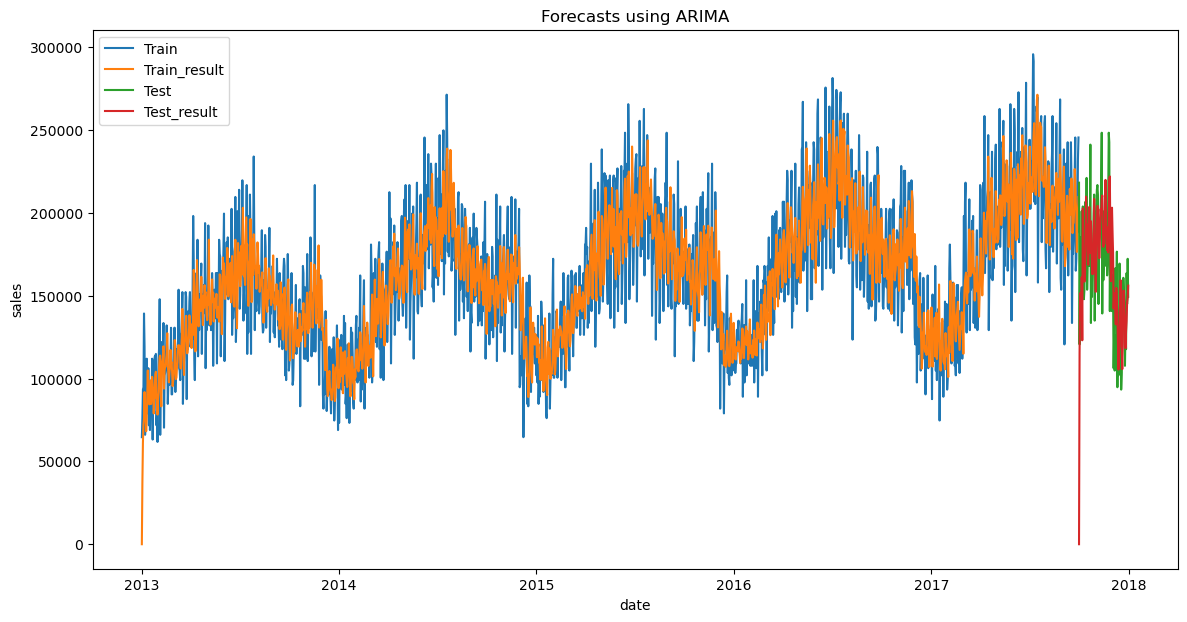

In [200]:
#visualizing forecaste
plt.figure(figsize=(14,7))
plt.plot(obs1_train['date'], obs1_train['sales'], label='Train')
plt.plot(obs1_train['date'], arima_train_result, label='Train_result')
plt.plot(obs1_test['date'], obs1_test['sales'], label='Test')
plt.plot(obs1_test['date'], arima_test_result, label='Test_result')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using ARIMA')
plt.show()

In [168]:
#applying sarima for training set
sarima = SARIMAX(obs1_train['sales'],
                order=(1,1,7),
                seasonal_order=(1,1,1,12))
sarima_train_result = sarima.fit().predict()

In [169]:
#applying sarima for testing set
sarima = SARIMAX(obs1_test['sales'],
                order=(1,1,7),
                seasonal_order=(1,1,1,12))
sarima_test_result = sarima.fit().predict()

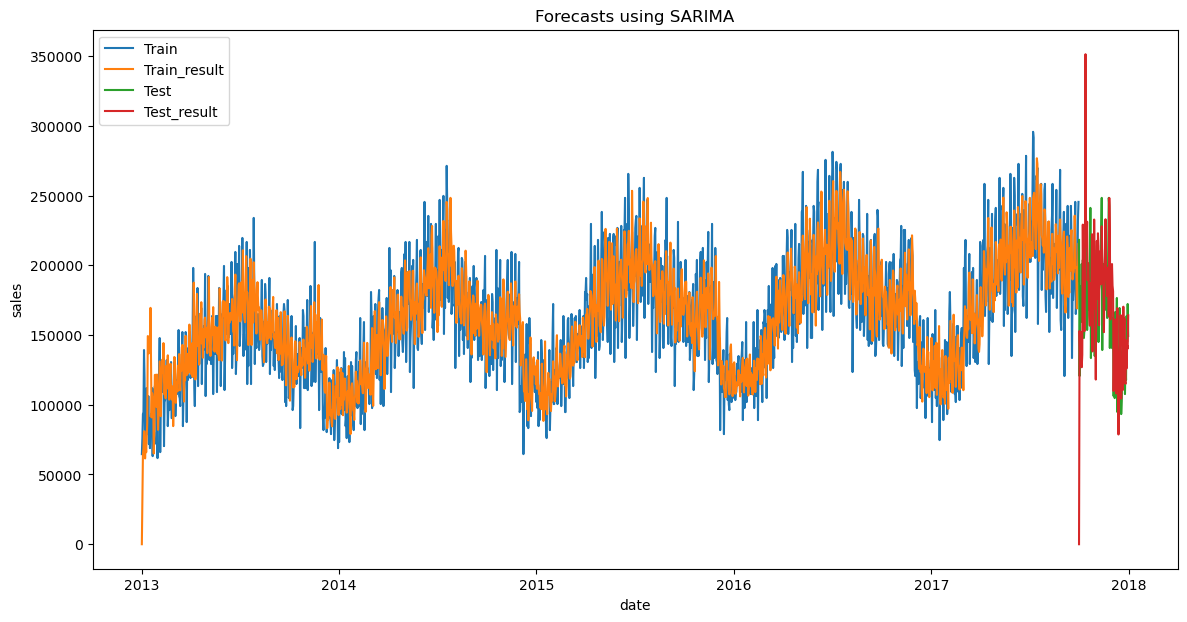

In [170]:
#visualizing forecaste
plt.figure(figsize=(14,7))
plt.plot(obs1_train['date'], obs1_train['sales'], label='Train')
plt.plot(obs1_train['date'], sarima_train_result, label='Train_result')
plt.plot(obs1_test['date'], obs1_test['sales'], label='Test')
plt.plot(obs1_test['date'], sarima_test_result, label='Test_result')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using SARIMA')
plt.show()

In [171]:
#calculating error
sarima_err = obs1_test['sales'] - sarima_test_result

In [172]:
#print MAE MAPE
print(f'MAE Score : ', mae(sarima_err))
print(f'MAPE Score : ', mape(sarima_err))

MAE Score :  29505.637323704163
MAPE Score :  17.493197443779586


In [173]:
performance['SARIMA'] = [mae(sarima_err), mape(sarima_err)]
performance

,random_forest,ARIMA,SARIMA
MAE,19183.635008,23296.891152,29505.637324
MAPE,10.582231,13.812178,17.493197


# Random forest is having lowest MAPE value so we will do forecasting using that 

# Lets try our random forest model for forecasting

In [174]:
X_final_test.head()

,year,month,weekday,week
0,2018,1,0,1
1,2018,1,1,1
2,2018,1,2,1
3,2018,1,3,1
4,2018,1,4,1


In [175]:
X_forecaste =get_pca(X_final_test)

In [176]:
#forecasting
y_pred_train, y_forecaste, score = random_forest(X1_train, y1_train, X_forecaste)

In [177]:
y = pd.DataFrame(y1)
y_forecaste = pd.DataFrame(y_forecaste)

In [178]:
len(y_forecaste)

31

In [179]:
forecaste = pd.concat([y, y_forecaste], axis=0, ignore_index=True)

In [180]:
forcaste = forecaste.reset_index(drop=True)

In [181]:
forcaste

,sales,0
0,64591.0,NaN
1,76074.0,NaN
2,93298.0,NaN
3,94733.0,NaN
4,139229.0,NaN
...,...,...
1852,NaN,161513.302536
1853,NaN,139763.030857
1854,NaN,128530.207065
1855,NaN,129149.581647


In [182]:
forecaste_sales = forecaste[0][-31:]
forecaste_sales = forecaste_sales.reset_index(drop = True)
forecaste_sales

0      82886.698286
1     110892.683353
2     124860.149282
3     141379.151557
4     132307.714332
5      90540.633389
6      90540.633389
7      89289.755453
8     108300.369165
9     157516.521150
10    181371.532961
11    154766.633084
12    115772.831146
13    120662.018608
14    108882.248339
15    125903.254508
16    173633.271900
17    213897.203908
18    174114.833284
19    143279.131708
20    139763.030857
21    120586.548980
22    128082.493745
23    207860.181824
24    222219.267613
25    210242.899795
26    161513.302536
27    139763.030857
28    128530.207065
29    129149.581647
30    185500.235968
Name: 0, dtype: float64

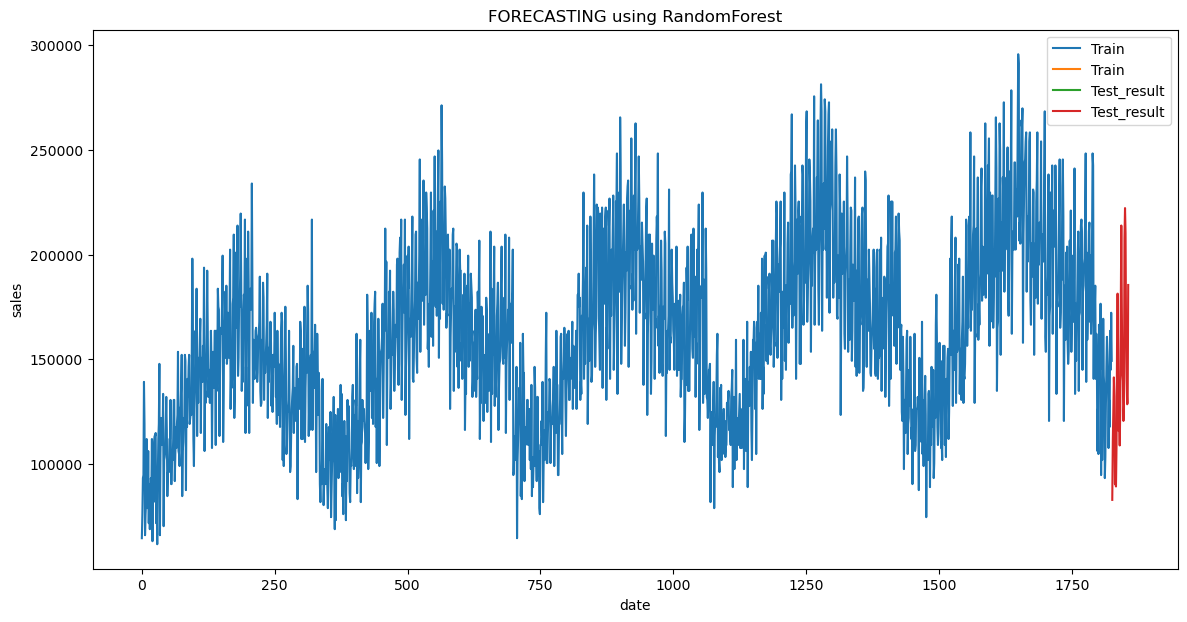

In [201]:
#plot target test and predicted value for DecisionTree
plt.figure(figsize=(14,7))
plt.plot(forecaste[:-31], label='Train')

plt.plot(forecaste[-31:], label='Test_result')

plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('FORECASTING using RandomForest')
plt.show()

# Using Random Forest forecasting is quite good with MAPE of 11%  with safety stock of 5%

# Fancy Cider Perry 500 ml is the product for which we have done forecasting for Guadalajara store city

# To convert it into hecto litres we should divide the sales with 100000

In [225]:
forecast_hectolitre = forecaste_sales * 500 / 100000
forecast_hectolitre

0      414.433491
1      554.463417
2      624.300746
3      706.895758
4      661.538572
5      452.703167
6      452.703167
7      446.448777
8      541.501846
9      787.582606
10     906.857665
11     773.833165
12     578.864156
13     603.310093
14     544.411242
15     629.516273
16     868.166360
17    1069.486020
18     870.574166
19     716.395659
20     698.815154
21     602.932745
22     640.412469
23    1039.300909
24    1111.096338
25    1051.214499
26     807.566513
27     698.815154
28     642.651035
29     645.747908
30     927.501180
Name: 0, dtype: float64